In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 13, 'font.family': 'NanumGothic'})

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

# 1. 데이터 수집

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import folium
import branca.colormap as cm
from folium.features import CustomIcon

In [22]:
시금치_df = pd.read_excel('/content/시금치_도매량.xlsx')
배추_df = pd.read_excel('/content/배추_도매량.xlsx')
대파_df = pd.read_excel('/content/대파_도매량.xlsx')
날씨_df = pd.read_csv('/content/날씨데이터.csv', encoding='cp949')
생산지_좌표 = pd.read_csv("/content/origins_coords_full.csv")
도매시장_좌표 = pd.read_csv("/content/markets_coords_full.csv")
기상청_좌표 = pd.read_csv("/content/kma_stations_coords.csv")

# 2-1. 데이터전처리

In [27]:
시금치_df["DATE"] = pd.to_datetime(시금치_df["DATE"], errors="coerce")  # DATE를 datetime으로 변환
시금치_df = 시금치_df.dropna(subset=["산지-광역시도", "산지-시군구"]) #NaN 삭제
시금치_df["산지"] = (
    시금치_df["산지-광역시도"].astype(str).str.strip()
    + " "
    + 시금치_df["산지-시군구"].astype(str).str.strip()
) #광역시-시군구 연결

시금치_df["거래 단위(kg)"] = (
    시금치_df["거래단위"]
    .astype(str)
    .str.extract('(\\d+\\.?\\d*)') # 숫자 (정수 또는 소수점 포함) 추출
    .astype(float)
) # 거래 단위 정규화

시금치_df["표준물량_kg"] = 시금치_df["총거래물량"] * 시금치_df["거래 단위(kg)"]
시금치_df["1kg당_가격"] = (시금치_df["총거래금액"] / 시금치_df["표준물량_kg"])

total_days = 시금치_df["DATE"].nunique()
print(f"전체 시금치 데이터 기준 유효 날짜 수: {total_days}일")

group = (
    시금치_df.groupby("산지", as_index=False)
    .agg(
        총물량=("표준물량_kg", "sum"),
        총금액=("총거래금액", "sum"),
        등장일수=("DATE", "nunique")
    )
)

max_vol = group["총물량"].max()
max_val = group["총금액"].max()

group["생산량 규모"] = group["총물량"] / max_vol if max_vol > 0 else 0
group["가격 영향력"] = group["총금액"] / max_val if max_val > 0 else 0
group["데이터 품질"] = group["등장일수"] / total_days if total_days > 0 else 0
group["기상 민감도"] = 0.0

group["종합 점수"] = (
    group["생산량 규모"]
    + group["가격 영향력"]
    + group["데이터 품질"]
    + group["기상 민감도"]
) / 4

score_df = (
    group[["산지", "생산량 규모", "가격 영향력", "기상 민감도", "데이터 품질", "종합 점수"]]
    .sort_values("종합 점수", ascending=False)
    .reset_index(drop=True)
)

print(score_df.head(3))

전체 시금치 데이터 기준 유효 날짜 수: 1531일
        산지    생산량 규모    가격 영향력  기상 민감도    데이터 품질     종합 점수
0  경기도 포천시  0.032020  1.000000     0.0  0.980405  0.503106
1   경남 남해군  1.000000  0.179150     0.0  0.563684  0.435709
2  경기도 이천시  0.012299  0.398051     0.0  0.981711  0.348015


In [33]:
print(시금치_df["거래단위"].value_counts().head(10))
print(시금치_df[["총거래물량", "거래단위", "거래 단위(kg)"]].head())

거래단위
4kg상자      273350
0.5kg단      54425
4kg비닐봉지     32160
10kg상자      30226
8kg상자       28552
0.4kg단      23727
1kg단        17741
0.3kg단      17437
0.5kg상자     14546
4kg.        11959
Name: count, dtype: int64
    총거래물량    거래단위  거래 단위(kg)
0  9148.0   4kg상자        4.0
1  6644.0   4kg상자        4.0
2  6196.0   4kg상자        4.0
3  5920.0  0.5kg단        0.5
4  5188.0   4kg상자        4.0


# 2-2. 버블 차트로 분석 (시각화)

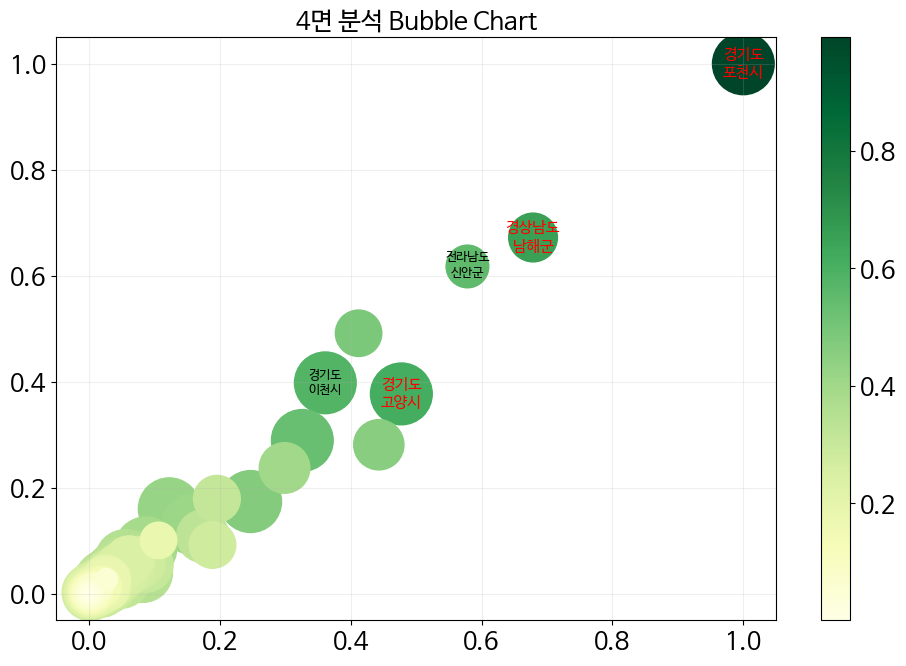

In [43]:
group_viz = (
    시금치_df.groupby("산지", as_index=False)
    .agg(
        총물량=("총거래물량", "sum"),
        총금액=("총거래금액", "sum"),
        등장일수=("DATE", "nunique")
    )
)

max_vol_viz = group_viz["총물량"].max()
max_val_viz = group_viz["총금액"].max()

group_viz["생산량 규모"] = group_viz["총물량"] / max_vol_viz if max_vol_viz > 0 else 0
group_viz["가격 영향력"] = group_viz["총금액"] / max_val_viz if max_val_viz > 0 else 0
group_viz["데이터 품질"] = group_viz["등장일수"] / total_days if total_days > 0 else 0
group_viz["기상 민감도"] = 0.0

group_viz["종합 점수"] = (
    group_viz["생산량 규모"]
    + group_viz["가격 영향력"]
    + group_viz["데이터 품질"]
) / 3

score_df_viz = (
    group_viz[["산지", "생산량 규모", "가격 영향력", "기상 민감도", "데이터 품질", "종합 점수"]]
    .sort_values("종합 점수", ascending=False)
    .reset_index(drop=True)
)

plt.figure(figsize=(10,7))

plt.scatter(
    score_df_viz["생산량 규모"],
    score_df_viz["가격 영향력"],
    s=score_df_viz["데이터 품질"] * 2000 + 10,
    c=score_df_viz["종합 점수"],
    cmap="YlGn"
)

top3  = score_df_viz.head(3)
top5 = score_df_viz.head(5)

for _, row in top5.iterrows():
    parts = row["산지"].split()
    label = parts[0] + "\n" + parts[1] if len(parts) >= 2 else row["산지"]

    if row["산지"] in top3["산지"].values:
        color = "red"
        fontsize = 11
        fontweight = "bold"
    else:
        color = "black"
        fontsize = 9
        fontweight = "normal"

    plt.text(
        row["생산량 규모"],
        row["가격 영향력"],
        label,
        fontsize=fontsize,
        fontweight=fontweight,
        color=color,
        ha='center',
        va='center'
    )

plt.title("4면 분석 Bubble Chart", fontsize=18)
plt.colorbar()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


# 2-3. 대표 산지 TOP N

In [23]:
TOP_N = 3

rep_origins = score_df.sort_values("종합 점수", ascending=False).head(TOP_N)
rep_origins = rep_origins[["산지"]].reset_index(drop=True)

print(f"대표 산지 TOP {TOP_N}:")
print()
print(rep_origins)

대표 산지 TOP 3:

         산지
0   경기도 포천시
1  경상남도 남해군
2   경기도 고양시


# 2-4. 대표 산지 -> 가장 가까운 도매시장 매핑

In [45]:
score_df[['광역시도','시군구']] = score_df['산지'].str.split(" ", expand=True)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return R * 2*np.arcsin(np.sqrt(a))

top_origins = score_df.sort_values("종합 점수", ascending=False).head(10)

mapping_results = []

for idx, row in top_origins.iterrows():
    o_city = row["광역시도"]
    o_county = row["시군구"]

    # 산지 좌표 찾기
    origin_row = 생산지_좌표[
        (생산지_좌표["광역시도"].str.contains(o_city)) &
        (생산지_좌표["시군구"].str.contains(o_county))
    ]

    if len(origin_row) == 0:
        continue

    o_lat = origin_row.iloc[0]["위도"]
    o_lon = origin_row.iloc[0]["경도"]

    # 도매시장 거리 계산
    도매시장_좌표["dist_km"] = 도매시장_좌표.apply(
        lambda x: haversine(o_lat, o_lon, x["위도"], x["경도"]),
        axis=1
    )

    nearest = 도매시장_좌표.sort_values("dist_km").iloc[0]

    mapping_results.append({
        "대표 산지": f"{o_city} {o_county}",
        "가까운 도매시장": nearest["도매시장"],
        "거리(km)": nearest["dist_km"]
    })

mapping_df = pd.DataFrame(mapping_results)

# 결과 확인
print(mapping_df)

# CSV 저장
mapping_df.to_csv("/content/origin_to_market_mapping.csv", index=False, encoding="utf-8-sig")

      대표 산지 가까운 도매시장     거리(km)
0   경기도 포천시   구리도매시장  32.254636
1    경남 남해군   순천도매시장  35.565899
2   경기도 이천시   수원도매시장  36.849278
3   경기도 고양시   서울강서도매  11.635300
4  경상남도 남해군   순천도매시장  35.565899
5  경기도 남양주시   구리도매시장   7.113121
6    전남 나주시   광주서부도매  17.812157
7    서울 송파구   서울가락도매   2.563116
8  전라남도 신안군   광주서부도매  75.371166


# 2-5. 대표 산지 ↔ 가장 가까운 기상청 지점 매칭

In [47]:
생산지_좌표["산지"] = 생산지_좌표["광역시도"].astype(str).str.strip() + " " + 생산지_좌표["시군구"].astype(str).str.strip()
rows = []

for _, row in rep_origins.iterrows():
    origin_name = row["산지"]

    org = 생산지_좌표[생산지_좌표["산지"] == origin_name]
    if org.empty:
        print(f"[경고] 산지 좌표 없음: {origin_name}")
        continue

    o_lat = org.iloc[0]["위도"]
    o_lon = org.iloc[0]["경도"]

    # 계산
    기상청_좌표["거리_km"] = 기상청_좌표.apply(
        lambda r: haversine(o_lat, o_lon, r["위도"], r["경도"]),
        axis=1
    )

    nearest = 기상청_좌표.sort_values("거리_km").iloc[0]
    rows.append({
        "대표 산지": origin_name,
        "기상_지점번호": nearest["지점"],
        "기상_지점명": nearest["지점명"],
        "거리_km": nearest["거리_km"]
    })

origin_kma_map = pd.DataFrame(rows)
print(origin_kma_map)

      대표 산지  기상_지점번호 기상_지점명      거리_km
0   경기도 포천시       98    동두천  12.273774
1  경상남도 남해군      295     남해   3.890506
2   경기도 고양시      108     서울  15.247197


# 2-6. 날씨 데이터와 날짜별로 실제로 merge 하기

In [52]:
mapping_df[["광역시도", "시군구"]] = mapping_df["대표 산지"].str.split(" ", expand=True)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

rep_origins = mapping_df[["대표 산지", "광역시도", "시군구"]].drop_duplicates().reset_index(drop=True)

rows = []

for _, row in rep_origins.iterrows():
    origin_name = row["대표 산지"]
    o_city = row["광역시도"]
    o_county = row["시군구"]

    cand = 생산지_좌표[
        (생산지_좌표["광역시도"].str.contains(o_city)) &
        (생산지_좌표["시군구"].str.contains(o_county))
    ]
    if cand.empty:
        print("[경고] 산지 좌표를 찾을 수 없음:", origin_name)
        continue

    o_lat = cand.iloc[0]["위도"]
    o_lon = cand.iloc[0]["경도"]

    기상청_좌표["dist_km"] = 기상청_좌표.apply(
        lambda s: haversine(o_lat, o_lon, s["위도"], s["경도"]),
        axis=1
    )

    nearest = 기상청_좌표.sort_values("dist_km").iloc[0]

    rows.append({
        "대표 산지": origin_name,
        "광역시도": o_city,
        "시군구": o_county,
        "기상_지점명": nearest["지점명"],
        "기상_지점번호": nearest["지점"],
        "산지↔기상거리(km)": nearest["dist_km"]
    })

rep_origin_weather_map = pd.DataFrame(rows)
print(rep_origin_weather_map)

      대표 산지  광역시도   시군구 기상_지점명  기상_지점번호  산지↔기상거리(km)
0   경기도 포천시   경기도   포천시    동두천       98    12.273774
1    경남 남해군    경남   남해군     남해      295     3.890506
2   경기도 이천시   경기도   이천시     이천      203     4.441802
3   경기도 고양시   경기도   고양시     서울      108    15.247197
4  경상남도 남해군  경상남도   남해군     남해      295     3.890506
5  경기도 남양주시   경기도  남양주시     서울      108    23.224010
6    전남 나주시    전남   나주시     광주      156    23.976403
7    서울 송파구    서울   송파구     서울      108    13.933157
8  전라남도 신안군  전라남도   신안군     목포      165    24.952019


# 3. 모델 구현

In [53]:
holidays_data = [
    ("2021-01-01", "신정"),
    ("2021-02-11", "설날 연휴"), ("2021-02-12", "설날"), ("2021-02-13", "설날 연휴"),
    ("2021-03-01", "삼일절"),
    ("2021-05-05", "어린이날"),
    ("2021-05-19", "부처님오신날"),
    ("2021-06-06", "현충일"),
    ("2021-08-15", "광복절"),
    ("2021-09-20", "추석 연휴"), ("2021-09-21", "추석"), ("2021-09-22", "추석 연휴"),
    ("2021-10-03", "개천절"),
    ("2021-10-09", "한글날"),
    ("2021-12-25", "크리스마스"),

    ("2022-01-01", "신정"),
    ("2022-01-31", "설날 연휴"), ("2022-02-01", "설날"), ("2022-02-02", "설날 연휴"),
    ("2022-03-01", "삼일절"),
    ("2022-05-05", "어린이날"),
    ("2022-05-08", "부처님오신날"),
    ("2022-06-06", "현충일"),
    ("2022-08-15", "광복절"),
    ("2022-09-09", "추석 연휴"), ("2022-09-10", "추석"), ("2022-09-11", "추석 연휴"),
    ("2022-10-03", "개천절"),
    ("2022-10-09", "한글날"),
    ("2022-12-25", "크리스마스"),

    ("2023-01-01", "신정"),
    ("2023-01-21", "설날 연휴"), ("2023-01-22", "설날"), ("2023-01-23", "설날 연휴"),
    ("2023-03-01", "삼일절"),
    ("2023-05-05", "어린이날"),
    ("2023-05-27", "부처님오신날"),
    ("2023-06-06", "현충일"),
    ("2023-08-15", "광복절"),
    ("2023-09-28", "추석 연휴"), ("2023-09-29", "추석"), ("2023-09-30", "추석 연휴"),
    ("2023-10-03", "개천절"),
    ("2023-10-09", "한글날"),
    ("2023-12-25", "크리스마스"),

    ("2024-01-01", "신정"),
    ("2024-02-09", "설날 연휴"), ("2024-02-10", "설날"), ("2024-02-11", "설날 연휴"),
    ("2024-03-01", "삼일절"),
    ("2024-05-05", "어린이날"),
    ("2024-05-15", "부처님오신날"),
    ("2024-06-06", "현충일"),
    ("2024-08-15", "광복절"),
    ("2024-09-16", "추석 연휴"), ("2024-09-17", "추석"), ("2024-09-18", "추석 연휴"),
    ("2024-10-03", "개천절"),
    ("2024-10-09", "한글날"),
    ("2024-12-25", "크리스마스"),

    ("2025-01-01", "신정"),
    ("2025-01-28", "설날 연휴"), ("2025-01-29", "설날"), ("2025-01-30", "설날 연휴"),
    ("2025-03-01", "삼일절"),
    ("2025-05-05", "어린이날"),
    ("2025-05-05", "부처님오신날"),  # 겹침
    ("2025-06-06", "현충일"),
    ("2025-08-15", "광복절"),
    ("2025-10-05", "추석 연휴"), ("2025-10-06", "추석"), ("2025-10-07", "추석 연휴"),
    ("2025-10-03", "개천절"),
    ("2025-10-09", "한글날"),
    ("2025-12-25", "크리스마스"),
]

holiday_df = pd.DataFrame(holidays_data, columns=["date","name"])
holiday_df["date"] = pd.to_datetime(holiday_df["date"])
holiday_df["is_holiday"] = 1

In [57]:
시금치_df["DATE"] = pd.to_datetime(시금치_df["DATE"], errors="coerce")
날씨_df["일시"] = pd.to_datetime(날씨_df["일시"], errors="coerce")
holiday_df["date"] = pd.to_datetime(holiday_df["date"], errors="coerce")
holiday_set = set(holiday_df["date"].dt.date)
def build_origin_weather(origin_kma_map, weather):
    rows = []
    for _, row in origin_kma_map.iterrows():
        origin = row["대표 산지"]
        stn = row["기상_지점번호"]

        sub = weather[weather["지점"] == stn].copy()
        if sub.empty:
            print(f"[경고] 기상 지점 {stn} ({row['기상_지점명']}) 데이터 없음")
            continue

        sub["대표 산지"] = origin
        sub = sub.rename(columns={"일시": "DATE"})
        rows.append(sub)

    dfw = pd.concat(rows, ignore_index=True)

    dfw = dfw[[
        "대표 산지", "DATE",
        "평균기온(°C)", "일강수량(mm)", "평균 상대습도(%)"
    ]]
    return dfw

origin_weather = build_origin_weather(origin_kma_map, 날씨_df)

def get_season(m):
    if m in [3, 4, 5]:
        return "spring"
    elif m in [6, 7, 8]:
        return "summer"
    elif m in [9, 10, 11]:
        return "fall"
    else:
        return "winter"

def is_holiday(date):
    return int(date.date() in holiday_set)
def build_model_v2(origin_name, market_name, min_samples=120, verbose=True):
    sub = 시금치_df[시금치_df["도매시장"] == market_name].copy()
    if sub.empty:
        if verbose:
            print(f"[스킵] {market_name} 데이터 없음")
        return None

    sub["평균가격"] = pd.to_numeric(sub["평균가격"], errors="coerce")
    sub["총거래물량"] = pd.to_numeric(sub["총거래물량"], errors="coerce")
    sub = sub.dropna(subset=["평균가격", "총거래물량"]) # Drop rows where conversion failed

    if sub.empty:
        if verbose:
            print(f"[스킵] {market_name} 데이터 없음 (numeric conversion 후).")
        return None

    daily = (
        sub.groupby("DATE", as_index=False)
        .agg(
            TARGET_PRICE=("평균가격", "mean"),
            TOTAL_VOL=("총거래물량", "sum")
        )
        .sort_values("DATE")
        .reset_index(drop=True)
    )

    w = origin_weather[origin_weather["대표 산지"] == origin_name].copy()
    if w.empty:
        if verbose:
            print(f"[스킵] {origin_name} 날씨 데이터 없음")
        return None

    df = pd.merge(daily, w, on="DATE", how="inner")
    if len(df) < min_samples:
        if verbose:
            print(f"[스킵] {origin_name} → {market_name} 샘플 수 부족: {len(df)}행")
        return None

    df = df.sort_values("DATE").reset_index(drop=True)

    for lag in [1, 3, 7]:
        df[f"LAG{lag}"] = df["TARGET_PRICE"].shift(lag)

    df["rolling_mean_3"] = df["TARGET_PRICE"].rolling(3).mean()
    df["rolling_mean_7"] = df["TARGET_PRICE"].rolling(7).mean()
    df["rolling_std_3"] = df["TARGET_PRICE"].rolling(3).std()
    df["rolling_std_7"] = df["TARGET_PRICE"].rolling(7).std()

    df["month"] = df["DATE"].dt.month
    df["weekday"] = df["DATE"].dt.weekday      # 0=월요일, ..., 6=일요일
    df["is_weekend"] = (df["weekday"] >= 5).astype(int)
    df["is_holiday"] = df["DATE"].apply(is_holiday)

    df["season"] = df["month"].apply(get_season)
    df = pd.get_dummies(df, columns=["season"], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    if len(df) < min_samples:
        if verbose:
            print(f"[스킵] {origin_name} → {market_name} (lag/rolling 후 샘플 부족: {len(df)}행)")
        return None

    feature_cols = [
        "TOTAL_VOL",
        "평균기온(°C)",
        "일강수량(mm)",
        "평균 상대습도(%)",
        "LAG1", "LAG3", "LAG7",
        "rolling_mean_3", "rolling_mean_7",
        "rolling_std_3", "rolling_std_7",
        "month", "weekday", "is_weekend", "is_holiday",
    ] + [c for c in df.columns if c.startswith("season_")]

    X = df[feature_cols]
    y = df["TARGET_PRICE"]

    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    model = RandomForestRegressor(
        n_estimators=800,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Corrected line
    mae = mean_absolute_error(y_test, y_pred)

    importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)

    if verbose:
        print("====================================")
        print(f"[V2] 대표 산지: {origin_name} → 도매시장: {market_name}")
        print(f"샘플 수: 전체={len(df)}, train={len(X_train)}, test={len(X_test)}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE : {mae:.2f}")
        print("\n[변수 중요도 Top 10]")
        print(importances.head(10))
        print("====================================\n")

    return {
        "origin": origin_name,
        "market": market_name,
        "rmse": rmse,
        "mae": mae,
        "importance": importances,
        "model": model,
    }

results_v2 = []

for _, row in mapping_df.iterrows():
    origin_name = row["대표 산지"]
    market_name = row["가까운 도매시장"]

    res = build_model_v2(origin_name, market_name, min_samples=120, verbose=True)
    if res is not None:
        results_v2.append(res)

if results_v2:
    summary_v2 = pd.DataFrame([
        {
            "대표 산지": r["origin"],
            "도매시장": r["market"],
            "RMSE": r["rmse"],
            "MAE": r["mae"],
        }
        for r in results_v2
    ])

    summary_v2 = summary_v2.sort_values("RMSE").reset_index(drop=True)
    print(summary_v2)
else:
    print("⚠ V2에서 학습된 모델이 없습니다. (샘플 수 조건 등을 확인해 주세요.)")

[V2] 대표 산지: 경기도 포천시 → 도매시장: 구리도매시장
샘플 수: 전체=575, train=460, test=115
RMSE: 3345.14
MAE : 2013.87

[변수 중요도 Top 10]
rolling_mean_3    0.857857
rolling_std_3     0.039546
rolling_std_7     0.026018
LAG1              0.012676
TOTAL_VOL         0.010987
rolling_mean_7    0.010802
LAG3              0.010239
평균기온(°C)          0.008052
일강수량(mm)          0.007221
LAG7              0.005700
dtype: float64

[스킵] 경남 남해군 날씨 데이터 없음
[스킵] 경기도 이천시 날씨 데이터 없음
[V2] 대표 산지: 경기도 고양시 → 도매시장: 서울강서도매
샘플 수: 전체=641, train=512, test=129
RMSE: 1340.17
MAE : 1008.57

[변수 중요도 Top 10]
rolling_mean_3    0.764952
rolling_std_3     0.063574
TOTAL_VOL         0.035977
rolling_std_7     0.034971
LAG1              0.020291
LAG7              0.016501
평균기온(°C)          0.016103
LAG3              0.014338
rolling_mean_7    0.010856
평균 상대습도(%)        0.009096
dtype: float64

[V2] 대표 산지: 경상남도 남해군 → 도매시장: 순천도매시장
샘플 수: 전체=477, train=381, test=96
RMSE: 7746.42
MAE : 3824.27

[변수 중요도 Top 10]
rolling_mean_3    0.508101
rolling_std_7 

# 4. 시각화

시각화 대상: 경기도 고양시 → 서울강서도매


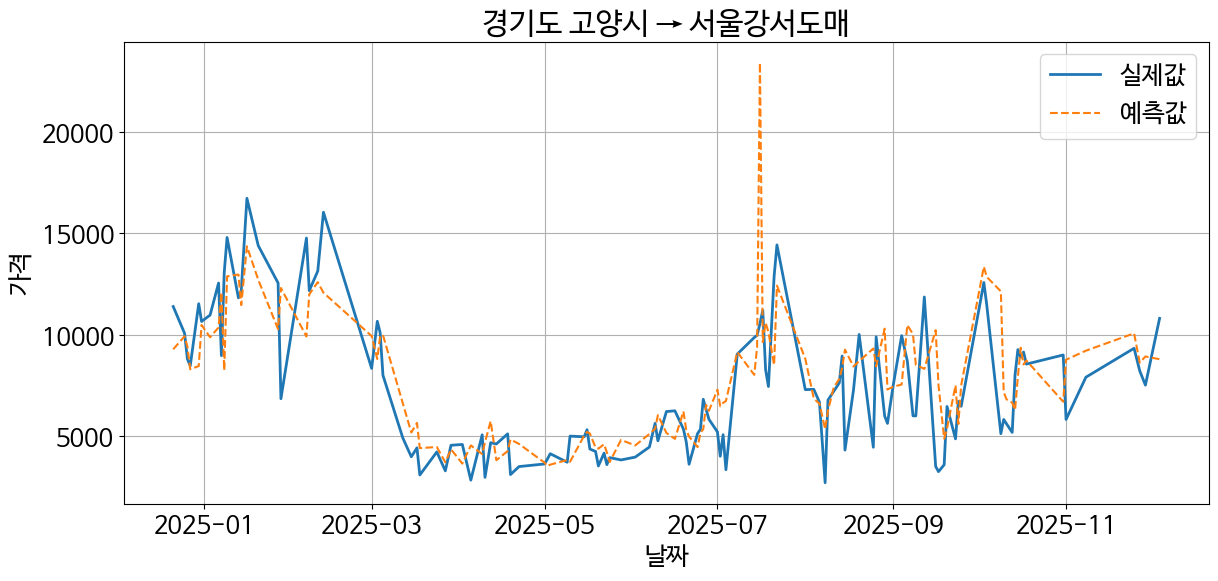

In [59]:
best = summary_v2.iloc[0]
origin_name = best["대표 산지"]
market_name = best["도매시장"]
print("시각화 대상:", origin_name, "→", market_name)

def get_season(m):
    if m in [3,4,5]: return "spring"
    if m in [6,7,8]: return "summer"
    if m in [9,10,11]: return "fall"
    return "winter"

def build_origin_weather(origin_name):
    row = origin_kma_map[origin_kma_map["대표 산지"] == origin_name]
    if row.empty: return None

    stn = row.iloc[0]["기상_지점번호"]

    sub = 날씨_df[날씨_df["지점"] == stn].copy()
    sub["DATE"] = sub["일시"]
    return sub

def prepare_df(origin_name, market_name):
    sub = 시금치_df[시금치_df["도매시장"] == market_name].copy()
    sub["평균가격"] = pd.to_numeric(sub["평균가격"], errors="coerce")
    sub["총거래물량"] = pd.to_numeric(sub["총거래물량"], errors="coerce")
    sub = sub.dropna(subset=["평균가격", "총거래물량"]) # Drop rows where conversion failed

    if sub.empty:
        print(f"[경고] {market_name} 데이터가 없습니다 (numeric conversion 후).")
        return None

    daily = (
        sub.groupby("DATE", as_index=False)
        .agg(
            TARGET_PRICE=("평균가격", "mean"),
            TOTAL_VOL=("총거래물량", "sum")
        )
        .sort_values("DATE")
    )

    w = build_origin_weather(origin_name)
    df = pd.merge(daily, w, on="DATE", how="inner")

    for lag in [1,3,7]:
        df[f"LAG{lag}"] = df["TARGET_PRICE"].shift(lag)

    df["month"] = df["DATE"].dt.month
    df["season"] = df["month"].apply(get_season)
    df = pd.get_dummies(df, columns=["season"], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = prepare_df(origin_name, market_name)

split = int(len(df) * 0.8)
test_df = df.iloc[split:].copy()

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=600, random_state=42)

feature_cols = [
    "TOTAL_VOL",
    "평균기온(°C)",
    "일강수량(mm)",
    "평균 상대습도(%)",
    "LAG1", "LAG3", "LAG7",
    "month"
] + [col for col in df.columns if col.startswith("season_")]

X = df[feature_cols]
y = df["TARGET_PRICE"]

model.fit(X.iloc[:split], y.iloc[:split])
test_df["pred"] = model.predict(X.iloc[split:])

plt.figure(figsize=(14,6))
plt.plot(test_df["DATE"], test_df["TARGET_PRICE"], label="실제값", linewidth=2)
plt.plot(test_df["DATE"], test_df["pred"], label="예측값", linestyle="--")

plt.title(f"{origin_name} → {market_name}")
plt.xlabel("날짜")
plt.ylabel("가격")
plt.legend()
plt.grid(True)
plt.show()

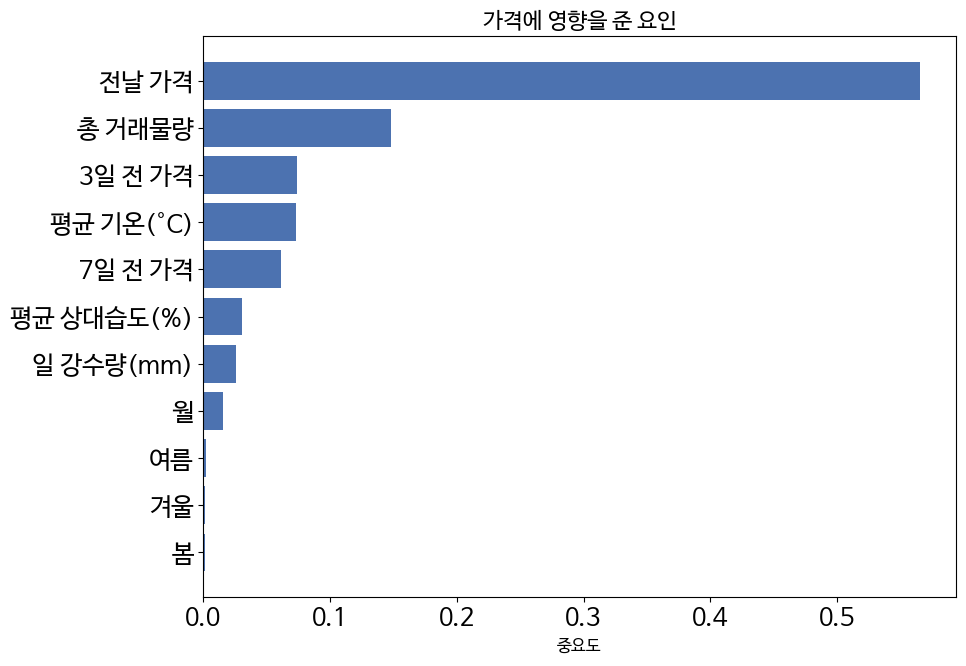

In [60]:
feature_name_map = {
    "TOTAL_VOL": "총 거래물량",
    "평균기온(°C)": "평균 기온(°C)",
    "일강수량(mm)": "일 강수량(mm)",
    "평균 상대습도(%)": "평균 상대습도(%)",

    "LAG1": "전날 가격",
    "LAG3": "3일 전 가격",
    "LAG7": "7일 전 가격",

    "rolling_mean_3": "3일 평균 가격",
    "rolling_mean_7": "7일 평균 가격",
    "rolling_std_3": "3일 가격 변동성",
    "rolling_std_7": "7일 가격 변동성",

    "month": "월",
    "weekday": "요일(0~6)",
    "is_weekend": "주말 여부",
    "is_holiday": "공휴일 여부",

    "season_spring": "봄",
    "season_summer": "여름",
    "season_fall": "가을",
    "season_winter": "겨울",
}

import matplotlib.pyplot as plt
import numpy as np

importance = model.feature_importances_
cols = X.columns

korean_labels = [feature_name_map.get(col, col) for col in cols]

sorted_idx = np.argsort(importance)
importance_sorted = importance[sorted_idx]
labels_sorted = np.array(korean_labels)[sorted_idx]

plt.figure(figsize=(10,7))
plt.barh(labels_sorted, importance_sorted, color="#4C72B0")
plt.title(f"가격에 영향을 준 요인", fontsize=16)
plt.xlabel("중요도", fontsize=12)
plt.tight_layout()
plt.show()

# 5. 일주일 치 가격예측

In [64]:
시금치_df["DATE"] = pd.to_datetime(시금치_df["DATE"], errors="coerce")
날씨_df["일시"] = pd.to_datetime(날씨_df["일시"], errors="coerce")
holiday_df["date"] = pd.to_datetime(holiday_df["date"], errors="coerce")

holiday_set = set(holiday_df["date"].dt.date)

def build_origin_weather(origin_kma_map, weather):
    rows = []
    for _, row in origin_kma_map.iterrows():
        origin = row["대표 산지"]
        stn = row["기상_지점번호"]

        sub = weather[weather["지점"] == stn].copy()
        if sub.empty:
            print(f"[경고] 기상 지점 {stn} ({row['기상_지점명']}) 데이터 없음")
            continue

        sub["대표 산지"] = origin
        sub = sub.rename(columns={"일시": "DATE"})
        rows.append(sub)

    dfw = pd.concat(rows, ignore_index=True)

    dfw = dfw[[
        "대표 산지", "DATE",
        "평균기온(°C)", "일강수량(mm)", "평균 상대습도(%)"
    ]]
    return dfw

origin_weather = build_origin_weather(origin_kma_map, 날씨_df)

def get_season(m):
    if m in [3, 4, 5]:
        return "spring"
    elif m in [6, 7, 8]:
        return "summer"
    elif m in [9, 10, 11]:
        return "fall"
    else:
        return "winter"

def is_holiday(date):
    return int(date.date() in holiday_set)

def make_feature_df(origin_name, market_name, min_samples=120):
    # 1) 해당 시장 데이터
    sub = 시금치_df[시금치_df["도매시장"] == market_name].copy()
    if sub.empty:
        print(f"[스킵] {market_name} 데이터 없음")
        return None

    # Explicitly convert to numeric and handle NaNs for aggregation
    sub["평균가격"] = pd.to_numeric(sub["평균가격"], errors="coerce")
    sub["총거래물량"] = pd.to_numeric(sub["총거래물량"], errors="coerce")
    sub = sub.dropna(subset=["평균가격", "총거래물량"]) # Drop rows where conversion failed

    if sub.empty:
        print(f"[스킵] {market_name} 데이터 없음 (numeric conversion 후).")
        return None

    daily = (
        sub.groupby("DATE", as_index=False)
        .agg(
            TARGET_PRICE=("평균가격", "mean"),
            TOTAL_VOL=("총거래물량", "sum")
        )
        .sort_values("DATE")
        .reset_index(drop=True)
    )

    # 2) 해당 산지 날씨
    w = origin_weather[origin_weather["대표 산지"] == origin_name].copy()
    if w.empty:
        print(f"[스킵] {origin_name} 날씨 데이터 없음")
        return None

    df = pd.merge(daily, w, on="DATE", how="inner")
    if len(df) < min_samples:
        print(f"[스킵] {origin_name} → {market_name} 샘플 수 부족: {len(df)}행")
        return None

    df = df.sort_values("DATE").reset_index(drop=True)

    # 3) lag
    for lag in [1, 3, 7]:
        df[f"LAG{lag}"] = df["TARGET_PRICE"].shift(lag)

    # 4) rolling
    df["rolling_mean_3"] = df["TARGET_PRICE"].rolling(3).mean()
    df["rolling_mean_7"] = df["TARGET_PRICE"].rolling(7).mean()
    df["rolling_std_3"] = df["TARGET_PRICE"].rolling(3).std()
    df["rolling_std_7"] = df["TARGET_PRICE"].rolling(7).std()

    # 5) 날짜 기반
    df["month"] = df["DATE"].dt.month
    df["weekday"] = df["DATE"].dt.weekday
    df["is_weekend"] = (df["weekday"] >= 5).astype(int)
    df["is_holiday"] = df["DATE"].apply(is_holiday)
    df["season"] = df["month"].apply(get_season)
    df = pd.get_dummies(df, columns=["season"], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    if len(df) < min_samples:
        print(f"[스킵] {origin_name} → {market_name} (lag/rolling 후 샘플 부족: {len(df)}행)")
        return None

    return df

def train_rf_v2(origin_name, market_name, min_samples=120, eval_valid=True):
    df = make_feature_df(origin_name, market_name, min_samples=min_samples)
    if df is None:
        return None, None

    feature_cols = [
        "TOTAL_VOL",
        "평균기온(°C)",
        "일강수량(mm)",
        "평균 상대습도(%)",
        "LAG1", "LAG3", "LAG7",
        "rolling_mean_3", "rolling_mean_7",
        "rolling_std_3", "rolling_std_7",
        "month", "weekday", "is_weekend", "is_holiday",
    ] + [c for c in df.columns if c.startswith("season_")]

    X = df[feature_cols]
    y = df["TARGET_PRICE"]

    if eval_valid:
        split_idx = int(len(df) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    else:
        # 전 데이터로 학습 (예측용)
        X_train, y_train = X, y
        X_test, y_test = None, None

    model = RandomForestRegressor(
        n_estimators=800,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_train, y_train)

    if eval_valid and X_test is not None and len(X_test) > 0:
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        print("====================================")
        print(f"[V2] {origin_name} → {market_name}")
        print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")
        print("====================================")

    return model, df

def get_weather_for_forecast(origin_name, target_date):
    """
    target_date와 같은 month/day의 과거 날씨가 있으면 사용,
    없으면 가장 마지막 날씨 사용.
    """
    ow = origin_weather[origin_weather["대표 산지"] == origin_name].copy()
    if ow.empty:
        return None

    # 같은 월/일, 가장 최근 연도
    same_md = ow[
        (ow["DATE"].dt.month == target_date.month) &
        (ow["DATE"].dt.day == target_date.day)
    ].sort_values("DATE")

    if not same_md.empty:
        row = same_md.iloc[-1]
    else:
        # fallback: 가장 최근 날짜
        row = ow.sort_values("DATE").iloc[-1]

    return {
        "평균기온(°C)": row["평균기온(°C)"],
        "일강수량(mm)": row["일강수량(mm)"],
        "평균 상대습도(%)": row["평균 상대습도(%)"],
    }

def forecast_next_7_days(origin_name, market_name):
    """
    - V2 feature 구조 그대로 사용
    - 전체 데이터를 사용해 모델 재학습
    - 마지막 날짜 이후 7일을 recursive하게 예측
    """
    # 1) 전체 데이터로 학습용 DF 생성
    df_full = make_feature_df(origin_name, market_name, min_samples=120)
    if df_full is None:
        print("예측 불가: 데이터 부족 또는 매핑 문제")
        return None

    feature_cols = [c for c in df_full.columns if c not in ["DATE", "TARGET_PRICE", "대표 산지"]]
    X_full = df_full[feature_cols]
    y_full = df_full["TARGET_PRICE"]

    model = RandomForestRegressor(
        n_estimators=800,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_full, y_full)

    history = df_full[["DATE","TARGET_PRICE","TOTAL_VOL","평균기온(°C)","일강수량(mm)","평균 상대습도(%)"]].copy()
    last_date = history["DATE"].max()

    forecasts = []

    for h in range(1, 8):
        target_date = last_date + pd.Timedelta(days=h)

        w_info = get_weather_for_forecast(origin_name, target_date)
        if w_info is None:
            print(f"[경고] {origin_name} 날씨 정보 없어 예측 중단")
            break

        vol_recent = history.tail(7)["TOTAL_VOL"]
        approx_vol = vol_recent.mean() if len(vol_recent) > 0 else history["TOTAL_VOL"].iloc[-1]

        new_row = {
            "DATE": target_date,
            "TARGET_PRICE": np.nan,
            "TOTAL_VOL": approx_vol,
            "평균기온(°C)": w_info["평균기온(°C)"],
            "일강수량(mm)": w_info["일강수량(mm)"],
            "평균 상대습도(%)": w_info["평균 상대습도(%)"],
        }
        history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)

        tmp = history.copy().sort_values("DATE").reset_index(drop=True)

        for lag in [1, 3, 7]:
            tmp[f"LAG{lag}"] = tmp["TARGET_PRICE"].shift(lag)
        tmp["rolling_mean_3"] = tmp["TARGET_PRICE"].rolling(3).mean()
        tmp["rolling_mean_7"] = tmp["TARGET_PRICE"].rolling(7).mean()
        tmp["rolling_std_3"] = tmp["TARGET_PRICE"].rolling(3).std()
        tmp["rolling_std_7"] = tmp["TARGET_PRICE"].rolling(7).std()

        tmp["month"] = tmp["DATE"].dt.month
        tmp["weekday"] = tmp["DATE"].dt.weekday
        tmp["is_weekend"] = (tmp["weekday"] >= 5).astype(int)
        tmp["is_holiday"] = tmp["DATE"].apply(is_holiday)
        tmp["season"] = tmp["month"].apply(get_season)
        tmp = pd.get_dummies(tmp, columns=["season"], drop_first=True)

        row_feat = tmp[tmp["DATE"] == target_date].iloc[-1]

        all_cols = list(row_feat.index)
        season_cols = [c for c in all_cols if c.startswith("season_")]

        feat_cols = [
            "TOTAL_VOL",
            "평균기온(°C)",
            "일강수량(mm)",
            "평균 상대습도(%)",
            "LAG1", "LAG3", "LAG7",
            "rolling_mean_3", "rolling_mean_7",
            "rolling_std_3", "rolling_std_7",
            "month", "weekday", "is_weekend", "is_holiday",
        ] + season_cols

        feat_vec = row_feat[feat_cols].fillna(method="ffill").fillna(method="bfill")

        y_hat = model.predict(feat_vec.values.reshape(1, -1))[0]

        history.loc[history["DATE"] == target_date, "TARGET_PRICE"] = y_hat

        forecasts.append({
            "DATE": target_date,
            "예측가격": y_hat,
            "가정_총거래물량": approx_vol,
            "가정_평균기온(°C)": w_info["평균기온(°C)"],
            "가정_일강수량(mm)": w_info["일강수량(mm)"],
            "가정_평균 상대습도(%)": w_info["평균 상대습도(%)"],
        })

    forecast_df = pd.DataFrame(forecasts)
    print(f"\n📅 {origin_name} → {market_name} 향후 7일 예측")
    print(forecast_df)

    return forecast_df

In [65]:
forecast_df = forecast_next_7_days("경기도 고양시", "서울강서도매")
forecast_df

/tmp/ipython-input-3954400438.py:267: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feat_vec = row_feat[feat_cols].fillna(method="ffill").fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3954400438.py:267: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feat_vec = row_feat[feat_cols].fillna(method="ffill").fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3954400438.py:267: FutureWarning: Series.fillna with 'method' is deprecated and will ra


📅 경기도 고양시 → 서울강서도매 향후 7일 예측
        DATE          예측가격      가정_총거래물량  가정_평균기온(°C)  가정_일강수량(mm)  \
0 2025-12-05  11542.428879  10742.642857          3.9          1.8   
1 2025-12-06   4882.136620  11539.877551          2.1          NaN   
2 2025-12-07  10773.253967  12302.145773          0.2          NaN   
3 2025-12-08  11663.245572  12814.380883         -0.2          NaN   
4 2025-12-09  11554.127812  12562.006723          1.0          NaN   
5 2025-12-10   9476.553245  12762.721970          2.6          NaN   
6 2025-12-11  13936.017576  12875.539394          3.0          NaN   

   가정_평균 상대습도(%)  
0           62.8  
1           49.3  
2           56.9  
3           46.5  
4           56.1  
5           58.9  
6           50.3  


,DATE,예측가격,가정_총거래물량,가정_평균기온(°C),가정_일강수량(mm),가정_평균 상대습도(%)
0,2025-12-05,11542.428879,10742.642857,3.9,1.8,62.8
1,2025-12-06,4882.136620,11539.877551,2.1,NaN,49.3
2,2025-12-07,10773.253967,12302.145773,0.2,NaN,56.9
3,2025-12-08,11663.245572,12814.380883,-0.2,NaN,46.5
4,2025-12-09,11554.127812,12562.006723,1.0,NaN,56.1
5,2025-12-10,9476.553245,12762.721970,2.6,NaN,58.9
6,2025-12-11,13936.017576,12875.539394,3.0,NaN,50.3


In [68]:
def forecast_three_origins_same_period(pairs):
    """
    pairs = [
        ("경기도 고양시", "서울강서도매"),
        ("경기도 포천시", "구리도매시장"),
        ("경상남도 남해군", "순천도매시장"),
    ]

    역할:
    1) 각 origin-market 조합의 마지막 데이터 날짜 조회
    2) 그 중 가장 최근 날짜를 기준일 기준으로 선택
    3) 모든 origin에 대해 기준일 이후 7일 동일 기간 예측
    """

    # 1) 각 origin의 마지막 실측 날짜 찾기
    last_dates = []
    for origin, market in pairs:
        df_full = make_feature_df(origin, market, min_samples=120)
        if df_full is None:
            print(f"[오류] {origin} → {market} 데이터 부족")
            return None
        last_dates.append(df_full["DATE"].max())

    # 기준일 = 세 산지 중 가장 최신 날짜
    base_last_date = max(last_dates)
    print("📌 기준일(last_date):", base_last_date.date())

    all_fc = []

    # 2) 각 origin-market 쌍에 대해 "기준일 이후 7일"만 예측
    for origin, market in pairs:
        fc = forecast_next_7_days_fixed(origin, market, base_last_date)
        if fc is not None:
            fc["대표 산지"] = origin
            fc["도매시장"] = market
            all_fc.append(fc)

    if not all_fc:
        print("❌ 예측 실패 (all_fc empty)")
        return None

    final = pd.concat(all_fc, ignore_index=True)

    # pivot (DATE 기준으로 산지별 가격 비교)
    pivot = final.pivot(index="DATE", columns="대표 산지", values="예측가격")
    pivot["최저가격"] = pivot.min(axis=1)
    pivot["최저산지"] = pivot.idxmin(axis=1)

    return pivot

def forecast_next_7_days_fixed(origin_name, market_name, base_last_date):
    """
    기존 forecast_next_7_days를 수정:
    - origin 내부의 실제 마지막 날짜와 관계없이
    - base_last_date 이후 7일을 예측
    """
    df_full = make_feature_df(origin_name, market_name, min_samples=120)
    if df_full is None:
        print(f"[예측불가] {origin_name} → {market_name}")
        return None

    # 모델 학습
    feature_cols = [c for c in df_full.columns if c not in ["DATE","TARGET_PRICE","대표 산지"]]
    X_full = df_full[feature_cols]
    y_full = df_full["TARGET_PRICE"]

    model = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_full, y_full)

    # 예측용 history
    history = df_full[["DATE","TARGET_PRICE","TOTAL_VOL","평균기온(°C)","일강수량(mm)","평균 상대습도(%)"]].copy()

    # 기준일 이후 날짜 생성
    forecasts = []
    for h in range(1, 8):
        target_date = base_last_date + pd.Timedelta(days=h)

        # 날씨 근사값
        w_info = get_weather_for_forecast(origin_name, target_date)
        if w_info is None:
            print(f"[경고] {origin_name} 날씨 없음 → 예측 중단")
            break

        # 근사 거래량
        approx_vol = history.tail(7)["TOTAL_VOL"].mean()

        # 새 날짜 row 넣기
        new_row = {
            "DATE": target_date,
            "TARGET_PRICE": np.nan,
            "TOTAL_VOL": approx_vol,
            "평균기온(°C)": w_info["평균기온(°C)"],
            "일강수량(mm)": w_info["일강수량(mm)"],
            "평균 상대습도(%)": w_info["평균 상대습도(%)"],
        }
        history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)

        # feature 다시 계산
        tmp = history.copy().sort_values("DATE").reset_index(drop=True)

        # lag/rolling
        for lag in [1,3,7]:
            tmp[f"LAG{lag}"] = tmp["TARGET_PRICE"].shift(lag)

        tmp["rolling_mean_3"] = tmp["TARGET_PRICE"].rolling(3).mean()
        tmp["rolling_std_3"]  = tmp["TARGET_PRICE"].rolling(3).std()
        tmp["rolling_mean_7"] = tmp["TARGET_PRICE"].rolling(7).mean()
        tmp["rolling_std_7"]  = tmp["TARGET_PRICE"].rolling(7).std()

        # 날짜 기반
        tmp["month"] = tmp["DATE"].dt.month
        tmp["weekday"] = tmp["DATE"].dt.weekday
        tmp["is_weekend"] = (tmp["weekday"] >= 5).astype(int)
        tmp["is_holiday"] = tmp["DATE"].apply(is_holiday)
        tmp["season"] = tmp["month"].apply(get_season)
        tmp = pd.get_dummies(tmp, columns=["season"], drop_first=True)

        row_feat = tmp[tmp["DATE"] == target_date].iloc[-1]
        season_cols = [c for c in row_feat.index if c.startswith("season_")]

        feat_cols = [
            "TOTAL_VOL","평균기온(°C)","일강수량(mm)","평균 상대습도(%)",
            "LAG1","LAG3","LAG7",
            "rolling_mean_3","rolling_mean_7",
            "rolling_std_3","rolling_std_7",
            "month","weekday","is_weekend","is_holiday"
        ] + season_cols

        feat_vec = row_feat[feat_cols].fillna(method="ffill").fillna(method="bfill")
        pred = model.predict(feat_vec.values.reshape(1,-1))[0]

        # 예측 반영
        history.loc[history["DATE"] == target_date, "TARGET_PRICE"] = pred

        forecasts.append({"DATE": target_date, "예측가격": pred})

    return pd.DataFrame(forecasts)

import matplotlib.pyplot as plt

def plot_global_min_forecast(pivot_df):
    """
    pivot_df : index=DATE, columns = 각 대표 산지 이름
               (필요하면 ['최저가격','최저산지'] 같은 열이 같이 있어도 됨)
    """

    # 1. 대표 산지 컬럼 추출
    origins = [c for c in pivot_df.columns if c not in ["최저가격", "최저산지"]]

    # 2. 7일 전체 중 '전역 최저가' 찾기
    stacked = pivot_df[origins].stack()         # (DATE, 산지) → 가격
    global_min_price = stacked.min()
    global_min_idx = stacked.idxmin()           # (DATE, 산지)
    global_min_date, global_min_origin = global_min_idx

    print("🔎 7일 전체 중 최저가")
    print(f"- 산지: {global_min_origin}")
    print(f"- 날짜: {global_min_date.date()}")
    print(f"- 가격: {global_min_price:,.0f}원")

    # 3. 선 그래프 그리기
    plt.figure(figsize=(12,5))
    for origin in origins:
        plt.plot(
            pivot_df.index, pivot_df[origin],
            marker='o', linewidth=2,
            label=origin
        )

    # 4. 전역 최저가 지점을 강하게 하이라이트
    plt.scatter(
        global_min_date,
        global_min_price,
        s=250,                 # 크기 키우기
        marker='*',
        color='red',
        edgecolors='black',
        linewidths=1.5,
        zorder=10,
        label="7일 중 최저가격"
    )

    # 5. 라벨(어느 산지·얼마인지) 달기
    label_text = f"{global_min_origin}\n{global_min_price:,.0f}원"
    plt.annotate(
        label_text,
        xy=(global_min_date, global_min_price),
        xytext=(0, 25),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=11,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1)
    )

    # 6. 기타 꾸미기
    plt.title("대표 산지 3곳 향후 7일 가격 예측", fontsize=15)
    plt.xlabel("날짜")
    plt.ylabel("예측 가격 (원)")
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.legend(
    fontsize=12,       # 글씨 크기 ↓
    markerscale=0.7,  # 선/마커 크기 ↓
    loc="best"        # 자동 위치 최적화
)
    plt.tight_layout()
    plt.show()


📌 기준일(last_date): 2025-12-04


/tmp/ipython-input-2214356511.py:133: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feat_vec = row_feat[feat_cols].fillna(method="ffill").fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/tmp/ipython-input-2214356511.py:133: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feat_vec = row_feat[feat_cols].fillna(method="ffill").fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/tmp/ipython-input-2214356511.py:133: FutureWarning: Series.fillna with 'method' is deprecated and will ra

🔎 7일 전체 중 최저가
- 산지: 경기도 고양시
- 날짜: 2025-12-06
- 가격: 4,882원


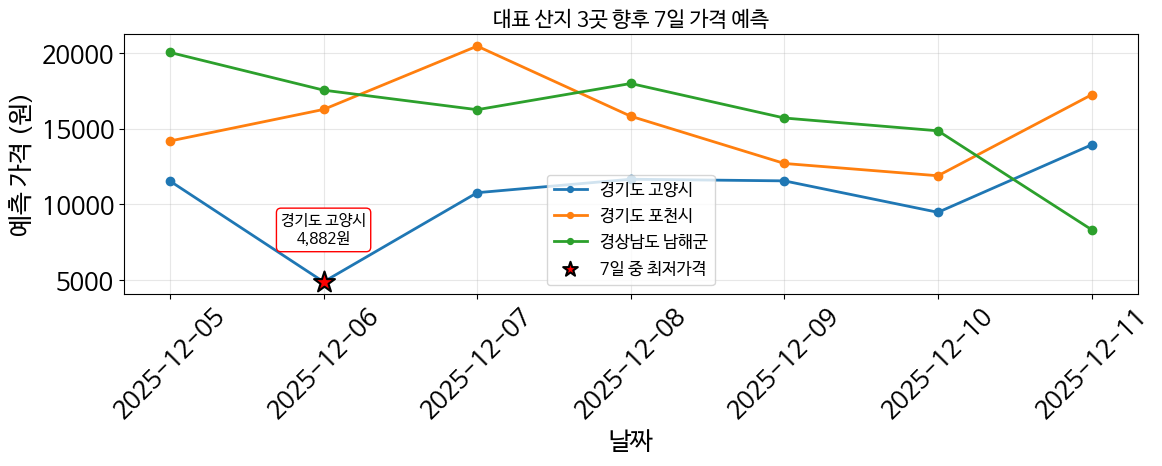

In [70]:
pairs = [
    ("경기도 고양시", "서울강서도매"),
    ("경기도 포천시", "구리도매시장"),
    ("경상남도 남해군", "순천도매시장"),
]

pivot = forecast_three_origins_same_period(pairs)

plot_global_min_forecast(pivot)

# 6. 시각화

In [71]:
!pip install folium

In [73]:
pred_rows = []

for _, row in origin_market_map.iterrows():
    origin = row["대표 산지"]
    market = row["가까운 도매시장"]

    try:
        fc = forecast_next_7_days(origin, market)  # 우리가 만든 함수 사용
        if fc is None or fc.empty:
            continue
        tomorrow_row = fc.iloc[0]  # 첫째 날 (내일)
        pred_rows.append({
            "대표 산지": origin,
            "도매시장": market,
            "내일예상가격": tomorrow_row["예측가격"]
        })
    except Exception as e:
        print(f"[경고] {origin} → {market} 예측 실패:", e)

pred_df = pd.DataFrame(pred_rows)
pred_df.head()

/tmp/ipython-input-3954400438.py:267: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feat_vec = row_feat[feat_cols].fillna(method="ffill").fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3954400438.py:267: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feat_vec = row_feat[feat_cols].fillna(method="ffill").fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3954400438.py:267: FutureWarning: Series.fillna with 'method' is deprecated and will ra


📅 경기도 포천시 → 구리도매시장 향후 7일 예측
        DATE          예측가격      가정_총거래물량  가정_평균기온(°C)  가정_일강수량(mm)  \
0 2025-12-05  14188.528646  10171.642857          1.3          NaN   
1 2025-12-06  16274.271440  10900.877551          0.8          NaN   
2 2025-12-07  20458.475162  11398.288630         -2.2          NaN   
3 2025-12-08  15824.829171  11736.044148         -2.4          NaN   
4 2025-12-09  12704.260302  10405.764741         -1.9          NaN   
5 2025-12-10  11892.305702  10518.552561         -0.6          NaN   
6 2025-12-11  17242.698340  10795.131498          0.8          NaN   

   가정_평균 상대습도(%)  
0           75.6  
1           47.4  
2           64.5  
3           55.0  
4           67.9  
5           69.3  
6           59.3  
[스킵] 경남 남해군 날씨 데이터 없음
예측 불가: 데이터 부족 또는 매핑 문제
[스킵] 경기도 이천시 날씨 데이터 없음
예측 불가: 데이터 부족 또는 매핑 문제


/tmp/ipython-input-3954400438.py:267: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feat_vec = row_feat[feat_cols].fillna(method="ffill").fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3954400438.py:267: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feat_vec = row_feat[feat_cols].fillna(method="ffill").fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3954400438.py:267: FutureWarning: Series.fillna with 'method' is deprecated and will ra


📅 경기도 고양시 → 서울강서도매 향후 7일 예측
        DATE          예측가격      가정_총거래물량  가정_평균기온(°C)  가정_일강수량(mm)  \
0 2025-12-05  11542.428879  10742.642857          3.9          1.8   
1 2025-12-06   4882.136620  11539.877551          2.1          NaN   
2 2025-12-07  10773.253967  12302.145773          0.2          NaN   
3 2025-12-08  11663.245572  12814.380883         -0.2          NaN   
4 2025-12-09  11554.127812  12562.006723          1.0          NaN   
5 2025-12-10   9476.553245  12762.721970          2.6          NaN   
6 2025-12-11  13936.017576  12875.539394          3.0          NaN   

   가정_평균 상대습도(%)  
0           62.8  
1           49.3  
2           56.9  
3           46.5  
4           56.1  
5           58.9  
6           50.3  


/tmp/ipython-input-3954400438.py:267: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feat_vec = row_feat[feat_cols].fillna(method="ffill").fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3954400438.py:267: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feat_vec = row_feat[feat_cols].fillna(method="ffill").fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3954400438.py:267: FutureWarning: Series.fillna with 'method' is deprecated and will ra


📅 경상남도 남해군 → 순천도매시장 향후 7일 예측
        DATE          예측가격     가정_총거래물량  가정_평균기온(°C)  가정_일강수량(mm)  \
0 2025-11-28  20030.430618   882.457143          6.6          NaN   
1 2025-11-29  17298.121364   960.522449          7.8          NaN   
2 2025-11-30  16137.323816  1034.454227         13.8          NaN   
3 2025-12-01  18043.774470  1123.519117         10.6          NaN   
4 2025-12-02  15800.647436  1191.836134          6.8          NaN   
5 2025-12-03  14873.827962  1140.812724          2.6          NaN   
6 2025-12-04   8344.541218  1093.943113          3.1          NaN   

   가정_평균 상대습도(%)  
0           58.3  
1           72.5  
2           78.3  
3           55.3  
4           45.8  
5           46.5  
6           60.0  
[스킵] 경기도 남양주시 날씨 데이터 없음
예측 불가: 데이터 부족 또는 매핑 문제
[스킵] 전남 나주시 날씨 데이터 없음
예측 불가: 데이터 부족 또는 매핑 문제
[스킵] 서울 송파구 날씨 데이터 없음
예측 불가: 데이터 부족 또는 매핑 문제
[스킵] 전라남도 신안군 날씨 데이터 없음
예측 불가: 데이터 부족 또는 매핑 문제


,대표 산지,도매시장,내일예상가격
0,경기도 포천시,구리도매시장,14188.528646
1,경기도 고양시,서울강서도매,11542.428879
2,경상남도 남해군,순천도매시장,20030.430618


In [74]:
origin_market_map = origin_market_map.rename(columns={'가까운 도매시장': '도매시장'})

# 산지 이름 통일
생산지_좌표["산지"] = 생산지_좌표["광역시도"].str.strip() + " " + 생산지_좌표["시군구"].str.strip()

# 대표 산지 좌표와 예측 가격 조인
origin_layer_df = (
    pred_df
    .merge(origin_market_map, on=["대표 산지","도매시장"])
    .merge(생산지_좌표[["산지","위도","경도"]], left_on="대표 산지", right_on="산지", how="left")
)

# 도매시장 좌표 + 내일 가격
market_layer_df = (
    pred_df
    .merge(도매시장_좌표, left_on="도매시장", right_on="도매시장", how="left")
)

In [77]:
price_min = market_layer_df["내일예상가격"].min()
price_max = market_layer_df["내일예상가격"].max()
cmap = cm.linear.YlOrRd_09.scale(price_min, price_max)
cmap.caption = "내일 예상 가격 (원)"

m = folium.Map(
    location=[36.5, 127.8],  # 한국 대충 가운데
    zoom_start=6,            # 기존 7보다 살짝 줌아웃
    tiles=None,
    width="900px",
    height="500px",
)

# 도시 이름 없는 밝은 회색 타일
folium.TileLayer(
    tiles=(
        "https://{s}.basemaps.cartocdn.com/light_nolabels/"
        "{z}/{x}/{y}{r}.png"
    ),
    attr="&copy; <a href='https://carto.com/attributions'>CARTO</a>",
    name="Base map",
    control=False,
).add_to(m)

spinach_icon = CustomIcon("/content/시금치.jpg", icon_size=(30, 30))
market_icon  = CustomIcon("/content/도매시장.png",  icon_size=(28, 28))

fg_origins = folium.FeatureGroup(name="시금치 생산지", show=True)

for _, r in origin_layer_df.iterrows():
    lat = r["위도"]
    lon = r["경도"]
    if pd.isna(lat) or pd.isna(lon):
        continue

    price = r["내일예상가격"]

    popup_html = f"""
    <div style="font-size:13px; line-height:1.4;">
      <b>{r['대표 산지']}</b><br>
      가까운 도매시장: {r['도매시장']}<br>
      내일 예상 가격: <b>{price:,.0f}원</b>
    </div>
    """

    popup = folium.Popup(popup_html, max_width=260, min_width=200)

    folium.Marker(
        location=[lat, lon],
        popup=popup,
        icon=spinach_icon,
    ).add_to(fg_origins)


fg_origins.add_to(m)

fg_markets = folium.FeatureGroup(name="도매시장 (내일 예상 가격)", show=True)

for _, r in market_layer_df.iterrows():
    lat = r["위도"]
    lon = r["경도"]
    if pd.isna(lat) or pd.isna(lon):
        continue

    price = r["내일예상가격"]
    color = cmap(price)

    popup_html = f"""
    <div style="font-size:13px; line-height:1.4;">
      <b>{r['도매시장']}</b><br>
      내일 예상 가격: <b>{price:,.0f}원</b>
    </div>
    """

    popup = folium.Popup(popup_html, max_width=260, min_width=200)

    folium.Marker(
        location=[lat, lon],
        popup=popup,
        icon=market_icon,
    ).add_to(fg_markets)

    folium.CircleMarker(
        location=[lat, lon],
        radius=7,
        color=color,
        weight=1,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
    ).add_to(fg_markets)


fg_markets.add_to(m)

all_lats = pd.concat([origin_layer_df["위도"], market_layer_df["위도"]])
all_lons = pd.concat([origin_layer_df["경도"], market_layer_df["경도"]])

sw = [all_lats.min() - 0.3, all_lons.min() - 0.3]  # 남서쪽
ne = [all_lats.max() + 0.3, all_lons.max() + 0.3]  # 북동쪽
m.fit_bounds([sw, ne])  # ⬅️ 이걸로 “원 범위” 자동 조정

links_df = origin_layer_df.merge(
    market_layer_df[["도매시장", "위도", "경도"]],
    on="도매시장",
    how="inner",
    suffixes=("_origin", "_market")
)

fg_links = folium.FeatureGroup(name="생산지-도매시장 연결", show=True)

for _, r in links_df.iterrows():
    lat_o, lon_o = r["위도_origin"], r["경도_origin"]   # 생산지
    lat_m, lon_m = r["위도_market"], r["경도_market"]   # 도매시장

    if pd.isna(lat_o) or pd.isna(lon_o) or pd.isna(lat_m) or pd.isna(lon_m):
        continue

    folium.PolyLine(
        locations=[(lat_o, lon_o), (lat_m, lon_m)],
        color="red",
        weight=2.5,
        opacity=0.6
    ).add_to(fg_links)

fg_links.add_to(m)

cmap.add_to(m)
folium.LayerControl(collapsed=True).add_to(m)

m
m.save("spinach_supply_chain_map_icons.html")
print("새 지도 저장 완료: spinach_supply_chain_map_icons.html")

새 지도 저장 완료: spinach_supply_chain_map_icons.html
